In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.utils import generic_utils
from keras.utils import Sequence
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments


In [34]:
train_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_Train_with_TRUE_85500inds.feather")
print(train_df.columns)
print(train_df.shape)
print("Number of inds in train:", train_df.shape[0]/29)
test_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_Test_with_TRUE_9699inds.feather")
print(test_df.columns)
print(test_df.shape)
print("Number of inds in test:", test_df.shape[0]/29)

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=190)
(2479500, 190)
Number of inds in train: 85500.0
Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=190)
(281271, 190)
Number of inds in test: 9699.0


In [35]:
# set length to 20
train_df = copy.deepcopy(train_df[train_df['QUARTER']>8])
test_df = copy.deepcopy(test_df[test_df['QUARTER']>8])
print(train_df.shape[0]/20)
print(test_df.shape[0]/20)
# remove true values
# remove QUARTER
train_df = train_df.drop(['QUARTER'], axis=1)
test_df = test_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(train_df.iloc[:, :-7].values)
test_v = copy.deepcopy(test_df.iloc[:, :-7].values)
print(train_v.shape)
print(train_v.shape[0]/20)
print(test_v.shape)
print(test_v.shape[0]/20)

85500.0
9699.0
(1710000, 182)
85500.0
(193980, 182)
9699.0


In [36]:
# standardise data
# z = (X - u)/s
# u is the mean of the training samples
# s is the standard devidation of the training samples
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_v) 
scaled_test = scaler.transform(test_v)

In [37]:
print('LL_PDC:', train_df.columns.get_loc('LL_PDC'))

LL_PDC: 28


In [38]:
def setup_xy(time_series, scaled_time_series, obs_steps):
    num_of_inds = time_series.shape[0]//20
    n_features = time_series.shape[1]
    
    _x = np.empty((num_of_inds, 
                   n_features+(n_features-1)*(obs_steps-1)), 
                   dtype='float')
    _y = np.empty((num_of_inds, 2), dtype='float') # 3, 
    ###############################################
    # construct x and y  flatten times series 
    # to 1 row.
    ###############################################
    for i in range(num_of_inds):
        scaled_ind_v = copy.deepcopy(scaled_time_series[(i*20):((i+1)*20), :])
        scaled_ind_v = scaled_ind_v[(16-obs_steps):16, :]
        _x[i, :n_features] = copy.deepcopy(scaled_ind_v[0, :])
        for j in range(1, (obs_steps)):
            start_idx = (j-1)*(n_features-1)+n_features
            end_idx = start_idx + (n_features-1)
            _x[i, start_idx:end_idx] = copy.deepcopy(scaled_ind_v[j, 1:])
        ind_v = copy.deepcopy(time_series[(i*20):((i+1)*20), :])
        if sum(ind_v[16:20, 28])/4 >= 80:
            _y[i, 0] = 0.0
            _y[i, 1] = 1.0
        else:
            _y[i, 0] = 1.0
            _y[i, 1] = 0.0
    return _x, _y

In [39]:
print(train_v.shape)
print(scaled_train.shape)
print(test_v.shape)
print(scaled_test.shape)

x_train, y_train = setup_xy(train_v, scaled_train, 4)
x_test, y_test = setup_xy(test_v, scaled_test, 4)
#x_train, y_train = set_up_xy_aggregate(scaled_train)
#x_test, y_test = set_up_xy_aggregate(scaled_test)
print("x train", x_train.shape)
print("y train", y_train.shape)
print("x test", x_test.shape)
print("y test", y_test.shape)

(1710000, 182)
(1710000, 182)
(193980, 182)
(193980, 182)
x train (85500, 725)
y train (85500, 2)
x test (9699, 725)
y test (9699, 2)


In [41]:
def setup_model(n_units, dropout_rate_1, dropout_rate_2):
    model = Sequential()
    model.add(Dense(n_units, activation='relu', 
                    #kernel_regularizer=regularizers.l2(0.01),
                    input_shape=(725, ))) #2897 2173 1449, 725
    model.add(Dropout(dropout_rate_1))
    model.add(Dense(n_units, activation='relu'))
                    #kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(dropout_rate_2))
    model.add(Dense(2, activation='softmax')) #20
                   #kernel_regularizer=regularizers.l2(0.01)))
    #sgdm = optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-4)  #1e-4
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])
    return model

In [42]:
def fit_model(model, X_train, Y_train, b_size):
    val_weight = "MLP_val_weights.hdf5"
    val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                         monitor='val_loss', verbose=1,
                                         save_best_only=True)
    history = model.fit(X_train, Y_train,
                        batch_size=b_size, 
                        epochs=50, 
                        validation_split=0.1, 
                        callbacks=[val_checkpointer], 
                        verbose=2, 
                        shuffle=False)
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    return min(history.history['val_loss']), val_weight

8550
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 1s - loss: 0.5572 - acc: 0.7331 - val_loss: 0.3707 - val_acc: 0.8531

Epoch 00001: val_loss improved from inf to 0.37069, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.4138 - acc: 0.8404 - val_loss: 0.3461 - val_acc: 0.8621

Epoch 00002: val_loss improved from 0.37069 to 0.34610, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.3846 - acc: 0.8526 - val_loss: 0.3398 - val_acc: 0.8674

Epoch 00003: val_loss improved from 0.34610 to 0.33981, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3736 - acc: 0.8577 - val_loss: 0.3364 - val_acc: 0.8673

Epoch 00004: val_loss improved from 0.33981 to 0.33636, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3657 - acc: 0.8599 - val_loss: 0.3361 - val_acc: 0.8665

Epoch 00005: val_loss improved from 0.33636 to 0.33605, saving model to MLP_val_weights.hdf5
Epoch 6/50
 - 1s - loss: 0.3613 - acc: 0.8619 - val_loss: 0.3346 

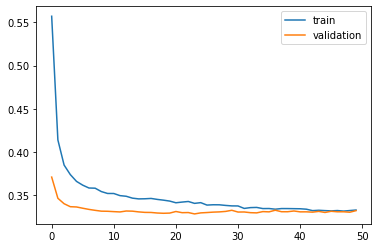

#################################
Number of units: 16
Batch size: 512
best val loss: 0.3279897253973442
#################################
Time to train MLP:  31.661744594573975
Entire process took:  31.731676816940308
Experiment record:
[[16, 512, 0, 0.3279897253973442]]


In [43]:
from numpy.random import seed
seed(2)
from tensorflow import set_random_seed
set_random_seed(2)

num_per_fold = x_train.shape[0]//10
print(num_per_fold)

n_units = 16
b_size = 512
dropout_rate_1 = 0.3886789590533535
dropout_rate_2 = 0.4319183635215759

start_time = time.time()

exp_record = []

for f in range(1):#10
    #start = f*num_per_fold
    end = (f+1)*num_per_fold
    train1_x = x_train[:end, ]
    train2_x = x_train[end:, ]
    train_x_mlp = np.append(train2_x, train1_x, axis=0) #new obj
    train1_y = y_train[:end, ]
    train2_y = y_train[end:, ]
    train_y_mlp = np.append(train2_y, train1_y, axis=0)

    start_time_inner = time.time()
    with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
        model = setup_model(n_units, dropout_rate_1, dropout_rate_2)
        v_loss, val_weight = fit_model(model, train_x_mlp,
                            train_y_mlp, b_size)
        print("#################################")
        print("Number of units:", n_units)
        print("Batch size:", b_size)
        print("best val loss:", v_loss)
        exp_record.append([n_units, b_size, f, v_loss])
        print("#################################")
        if (f==4):
            print(exp_record)
        model.load_weights(val_weight)
        yhat_test = model.predict(x_test)
        end_time = time.time()
        print("Time to train MLP: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

In [44]:
print(yhat_test.shape)
yhat_test_df = pd.DataFrame(yhat_test)
y_test_df = pd.DataFrame(y_test)
yhat_test_df.columns = ['NON_ADHERENT', 'ADHERENT']
y_test_df.columns = ['NON_ADHERENT', 'ADHERENT']
feather.write_dataframe(yhat_test_df, "/home/whsu014/data/Post_PREDICT_PDC_4to4_MLP_yhat.feather")
#feather.write_dataframe(y_test_df, "/home/whsu014/data/Post_PREDICT_PDC_y_MLP.feather")

(9699, 2)
